# Avito Deal Prediction: Stage 0 Model
This notebook contains the first model used in the 2018 Avito Kaggle challenge. It uses data generated from Stage 0 preprocessing / data exploration and features a Light GBM gradient boosting model.

In [1]:
import pandas as pd
import numpy as np
import os
import json
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import lightgbm as lgb

## Helper Functions:

In [2]:
def make_submission(test_predictions, item_id_list, csv_path):
    test_predictions = np.clip(test_predictions,0,1)
    rows = np.stack((item_id_list, test_predictions)).T
    df = pd.DataFrame(columns=['item_id', 'deal_probability'], data=rows)
    df.to_csv(csv_path, index=False)
    return None

## Setup Parameters:

### LightGBM Parameters:

In [3]:
# LightGBM Params
params = {}
params['learning_rate'] = 0.021
params['boosting_type'] = 'gbrt'
params['objective'] = 'regression'
params['metric'] = 'rmse'
params['num_leaves'] = 30
params['feature_fraction'] = 0.6
params['bagging_fraction'] = .8

### General Setup:

In [4]:
# Load parameters file
with open('setup_param.json', 'r') as handle:
    setup_params = json.load(handle)

In [5]:
parent_path = setup_params['parent_dir']
data_path = setup_params['data_dir']
scripts_path = setup_params['scripts_dir']
train_csv_path = setup_params['train_csv']
test_csv_path = setup_params['test_csv']

# Light GBM parameters
model_path_0 = setup_params['model_dir_0']

# Training and test sets
labels_path = setup_params['train_labels']
train_data_path = setup_params['stage0_train']

test_data_path = setup_params['stage0_test']
test_items_path = setup_params['test_items']

In [6]:
# Submission path
submission_path = model_path_0 + 'submission' + ".csv"

## Load Training and Test Data:

In [7]:
features_list = ['population', 'area', 'latitude', 'longitude', 'density', 'pcn_0',\
                 'pcn_1', 'pcn_2', 'pcn_3', 'pcn_4', 'pcn_5', 'pcn_6', 'pcn_7',\
                 'pcn_8', 'title_count', 'desc_count', 'usetyp_0', 'usetyp_1',\
                 'usetyp_2', 'price', 'image_top_1']
label_name = 'deal_probability'

In [8]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

dropped_features = [x for x in train.columns.values if x not in features_list]
# Drop features (if any)
train.drop(labels=dropped_features, axis=1, inplace=True)
test.drop(labels=dropped_features, axis=1, inplace=True)

In [9]:
if label_name == 'deal_probability':
    label_csv = pd.read_csv(labels_path)
    label_csv = label_csv.deal_prob.values
else:
    label_csv = np.asarray(train[label_name])

In [10]:
# Standardize data
sc = StandardScaler()
train = sc.fit_transform(train)
test = sc.transform(test)
# Reformat into pandas dataframe
train = pd.DataFrame(data=train, columns=features_list)
test = pd.DataFrame(data=test, columns=features_list)

In [11]:
# Get training, validation, and test split
train_df, val_df, train_label_df, val_label_df = train_test_split(train, label_csv, test_size=0.2, random_state=0)

In [12]:
# Format for LightGBM training
d_train = lgb.Dataset(train_df, label=train_label_df)
d_val = lgb.Dataset(val_df, label=val_label_df)

## Train LightGBM Model:

In [13]:
print 'Start training...'
evals_result = {}  # Record results for plotting
lgbm = lgb.train(params, d_train, num_boost_round=1000, valid_sets=[d_val], evals_result=evals_result, 
                 verbose_eval=100)

Start training...
[100]	valid_0's rmse: 0.238529
[200]	valid_0's rmse: 0.235589
[300]	valid_0's rmse: 0.234525
[400]	valid_0's rmse: 0.233879
[500]	valid_0's rmse: 0.233461
[600]	valid_0's rmse: 0.233183
[700]	valid_0's rmse: 0.232932
[800]	valid_0's rmse: 0.232726
[900]	valid_0's rmse: 0.232573
[1000]	valid_0's rmse: 0.232438


In [14]:
# Get predictions
train_pred = lgbm.predict(train)
test_pred=lgbm.predict(test)

Plot metrics recorded during training...


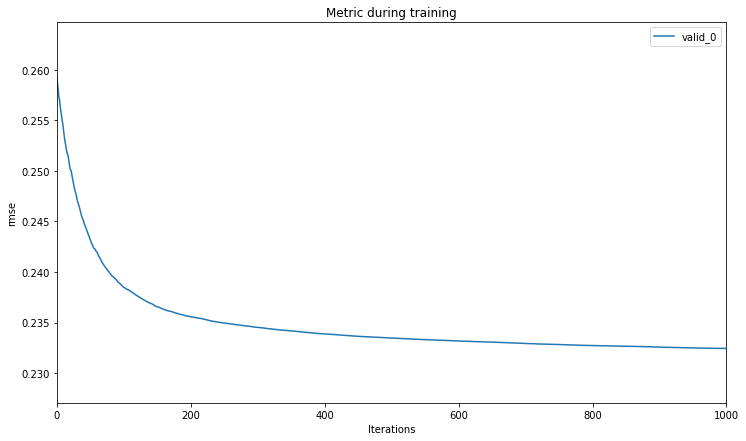

In [15]:
print('Plot metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='rmse', figsize=(12, 7), grid=False)

Plot feature importances...


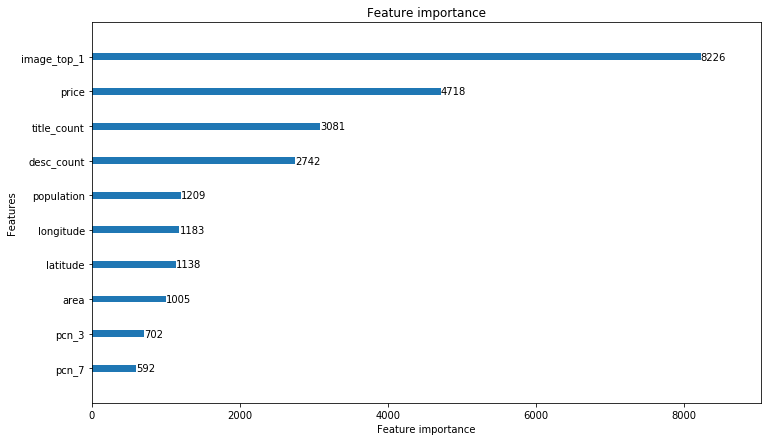

In [16]:
print('Plot feature importances...')
ax = lgb.plot_importance(lgbm, max_num_features=10, figsize=(12, 7), grid=False)

In [17]:
# Make submission script
with open(test_items_path, 'rb') as handle:
    test_item_id = pickle.load(handle)
make_submission(test_pred, test_item_id, submission_path)